<a href="https://colab.research.google.com/github/MANOJHRMANOJHR/ai_assignments/blob/main/sms_spam_tfidf_logreg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Classification report (test):
              precision    recall  f1-score   support

         ham       0.97      1.00      0.98       966
        spam       1.00      0.77      0.87       149

    accuracy                           0.97      1115
   macro avg       0.98      0.89      0.93      1115
weighted avg       0.97      0.97      0.97      1115

Test accuracy: 0.9695


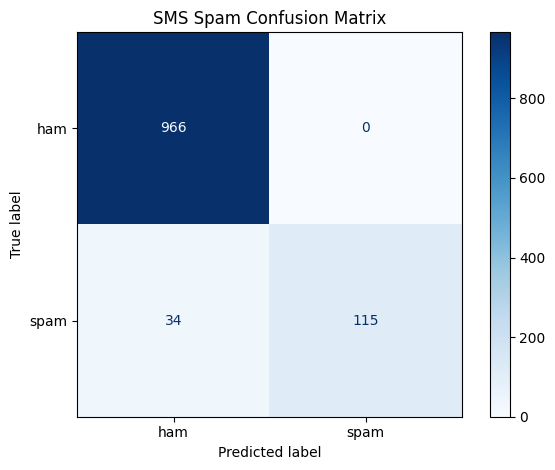

Saved: outputs/sms/cm_sms.png

Top 20 SPAM-indicative features:
txt                             4.305
mobile                          3.542
uk                              3.470
claim                           3.445
www                             3.276
reply                           3.066
stop                            3.025
free                            2.956
service                         2.832
150p                            2.718
prize                           2.561
text                            2.485
com                             2.431
50                              2.381
new                             2.233
won                             2.230
urgent                          2.189
cash                            2.147
win                             2.137
18                              2.015

Top 20 HAM-indicative features:
ok                             -1.931
ll                             -1.685
da                             -1.488
come                         

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

LOCAL_PATH = "SMSSpamCollection"  # fallback local filename (optional)
REMOTE_TSV = "https://raw.githubusercontent.com/justmarkham/pycon-2016-tutorial/master/data/sms.tsv"

def load_data():
    # Try local UCI file; else try remote TSV; else raise.
    if os.path.exists(LOCAL_PATH):
        df = pd.read_csv(LOCAL_PATH, sep="\t", header=None, names=["label", "message"])
        return df
    try:
        df = pd.read_csv(REMOTE_TSV, sep="\t", header=None, names=["label", "message"])
        return df
    except Exception as e:
        raise RuntimeError(
            "Could not load SMS dataset. Place 'SMSSpamCollection' next to this script "
            "or ensure internet is available."
        ) from e


def main():
    os.makedirs("outputs/sms", exist_ok=True)
    df = load_data()

    X_train, X_test, y_train, y_test = train_test_split(
        df["message"].values, df["label"].values,
        test_size=0.2, random_state=42, stratify=df["label"].values
    )

    vect = TfidfVectorizer(
        lowercase=True, stop_words="english", ngram_range=(1, 2),
        max_df=0.95, min_df=2
    )

    Xtr = vect.fit_transform(X_train)
    Xte = vect.transform(X_test)

    clf = LogisticRegression(penalty="l2", solver="liblinear", max_iter=1000)
    clf.fit(Xtr, y_train)

    y_pred = clf.predict(Xte)
    print("\nClassification report (test):")
    print(classification_report(y_test, y_pred, zero_division=0))
    print(f"Test accuracy: {accuracy_score(y_test, y_pred):.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=["ham", "spam"])
    disp = ConfusionMatrixDisplay(cm, display_labels=["ham", "spam"])
    disp.plot(cmap="Blues")
    plt.title("SMS Spam Confusion Matrix")
    plt.tight_layout()
    plt.savefig("outputs/sms/cm_sms.png", dpi=200)
    plt.show()
    print("Saved: outputs/sms/cm_sms.png")

    # Top positive/negative (toward "spam")
    feature_names = np.array(vect.get_feature_names_out())
    if clf.coef_.shape[0] == 1:
      coefs = clf.coef_[0]
    else:
      spam_idx = np.where(clf.classes_ == "spam")[0][0]
      coefs = clf.coef_[spam_idx]


    top_pos = np.argsort(coefs)[-20:][::-1]
    top_neg = np.argsort(coefs)[:20]

    print("\nTop 20 SPAM-indicative features:")
    for f, w in zip(feature_names[top_pos], coefs[top_pos]):
        print(f"{f:30s} {w: .3f}")

    print("\nTop 20 HAM-indicative features:")
    for f, w in zip(feature_names[top_neg], coefs[top_neg]):
        print(f"{f:30s} {w: .3f}")


if __name__ == "__main__":
    main()
